So far, we have only seen binary classification. But in real world scenario we come across multi-class classification.

In this excercise we will be Classifying Consumer Finance Complaints into 12 pre-defined classes. The data can be downloaded from [data.gov](https://catalog.data.gov/dataset/consumer-complaint-database)



The Consumer Complaint Database is a collection of complaints about consumer financial products and services that we sent to companies for response. 


Complaints are published after the company responds, confirming a commercial relationship with the consumer, or after 15 days, whichever comes first. 


Complaints referred to other regulators, such as complaints about depository institutions with less than $10 billion in assets, are not published in the Consumer Complaint Database. The database generally updates daily.



## Problem Definition

The problem is supervised text classification problem, and our goal is to decide which supervised machine learning methods are best suited to solve it.

Given a new complaint comes in, we want to assign it to one of 12 categories.

**The classifier makes the assumption that each new complaint is assigned to one and only one category.** This is multi-class text classification problem.


### Setup Chunk

In [1]:
%matplotlib inline

import time
import pandas as pd
from sklearn.pipeline import Pipeline

from sklearn.multiclass import OneVsRestClassifier
from sklearn import model_selection, naive_bayes, metrics, svm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

### Loading Dataset

There are two ways one of them is download the data from website and then upload it on colab.

Since datasize is (~800 MB) we will directly read it into our Dataframe


In [2]:
# Read the dataset
t1 = time.time()
import pandas as pd
df = pd.read_csv('https://files.consumerfinance.gov/ccdb/complaints.csv.zip')
t2 = time.time()
print(t2 - t1, "secs") 

df.head()

109.90799355506897 secs


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
2,2019-10-25,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I would like to request the suppression of the...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,937XX,NaN,Consent provided,Web,2019-10-25,Closed with explanation,Yes,NaN,3417821
3,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
4,2019-02-08,Vehicle loan or lease,Lease,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,HYUNDAI CAPITAL AMERICA,FL,33161,NaN,Consent not provided,Web,2019-02-08,Closed with non-monetary relief,Yes,NaN,3146310


In [4]:
df.shape

(1491590, 18)

for our problem we only need two columns 


1) Consumer Complaint Narrative


2) product

In [5]:
col = ['Product', 'Consumer complaint narrative'] # select required columns
df = df[col]
df['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    333703
Mortgage                                                                        294523
Debt collection                                                                 278526
Credit reporting                                                                140432
Credit card                                                                      89190
Bank account or service                                                          86206
Credit card or prepaid card                                                      67128
Checking or savings account                                                      56945
Student loan                                                                     56216
Consumer Loan                                                                    31604
Vehicle loan or lease                                                            15388
Money transfer, virtual currency, or money 

### Data Prepration

We will do some basic data cleaning like removing rows where reviews are not available & replacing each product with category id so that supervised algorithm understand better.

We also create a couple of dictionaries for future use.


We will be working on sample dataset for the demonstration

In [6]:
df = df.sample(frac=0.10,random_state=42,replace=True)

In [7]:
df.shape

(149159, 2)

In [8]:
from io import StringIO

df = df[pd.notnull(df['Consumer complaint narrative'])] # filter rows with non-null values

df.columns = ['Product', 'Consumer_complaint_narrative'] # create numeric categories
df['category_id'] = df['Product'].factorize()[0]
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
df.head()


,Product,Consumer_complaint_narrative,category_id
121958,Credit card or prepaid card,"On or around the date supplied, I called Capit...",0
1414414,Vehicle loan or lease,Toyota Financial Services is Charging an exces...,1
110268,Student loan,SO i started with fedloan the consodilation on...,2
1103462,Student loan,All of my loans from XXXX University are forgi...,2
999890,Credit reporting,I have disputed multiple items with Experian. ...,3


In [9]:
df.shape # after removing blank records we are left with ~48k reviews

(48929, 3)

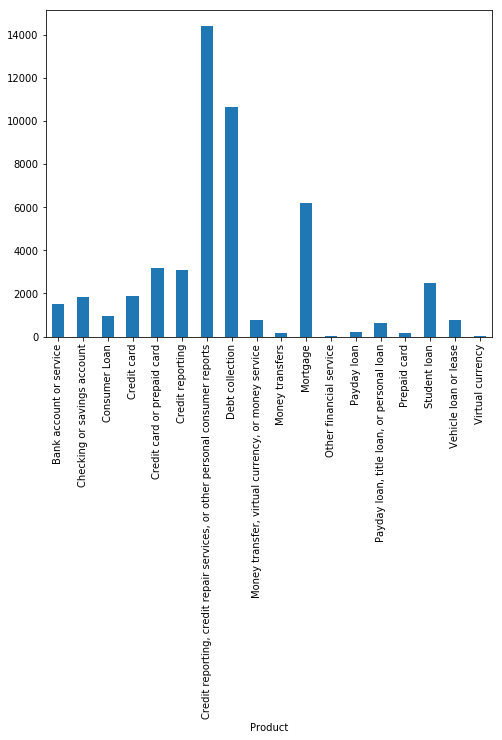

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [11]:
t1 = time.time()
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], test_size=0.3,random_state = 0)
t2= time.time()

print(t2-t1,"secs")

0.01000356674194336 secs


In [12]:
t1 = time.time()
# Represent the review text as a bag-of-words 
count_vect = CountVectorizer(lowercase=True,stop_words="english",min_df=10)
count_vect.fit(X_train)
X_train_counts = count_vect.transform(X_train)
X_test_counts = count_vect.transform(X_test)


# Create the tf-idf representation using the bag-of-words matrix
tfidf_transformer = TfidfTransformer(norm=None)
tfidf_transformer.fit(X_train_counts)
X_train_tfid =tfidf_transformer.transform(X_train_counts)
X_test_tfid = tfidf_transformer.transform(X_test_counts)

t2=time.time()

print(t2-t1," secs")


12.274997472763062  secs


### Naive Bayes Classifer

In [13]:
t1 = time.time()
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_tfid, y_train) # train naive bayes on count
print(time.time()-t1," Secs")

0.17499947547912598  Secs


In [14]:
print("Train Accuracy: ", nb.score(X_train_tfid,y_train))
print("Test Accuracy: ",nb.score(X_test_tfid,y_test))

Train Accuracy:  0.7502773722627737
Test Accuracy:  0.6509298998569385


Lets predict some random text

In [15]:
print(nb.predict(count_vect.transform(['''This company refuses to provide me verification and validation of debt per my right under the FDCPA. 
                                          I do not believe this debt is mine.'''])))

['Debt collection']


Some more

In [16]:
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test_tfid)
print(classification_report(y_test, y_pred,list(y_test.unique())))


                                                                              precision    recall  f1-score   support

                                                                 Credit card       0.41      0.44      0.42       558
Credit reporting, credit repair services, or other personal consumer reports       0.80      0.56      0.66      4388
                          Money transfer, virtual currency, or money service       0.60      0.65      0.62       241
                                                             Debt collection       0.82      0.72      0.77      3180
                                                            Credit reporting       0.32      0.58      0.41       933
                                                     Bank account or service       0.52      0.49      0.50       467
                                                                    Mortgage       0.89      0.90      0.90      1831
                                                       

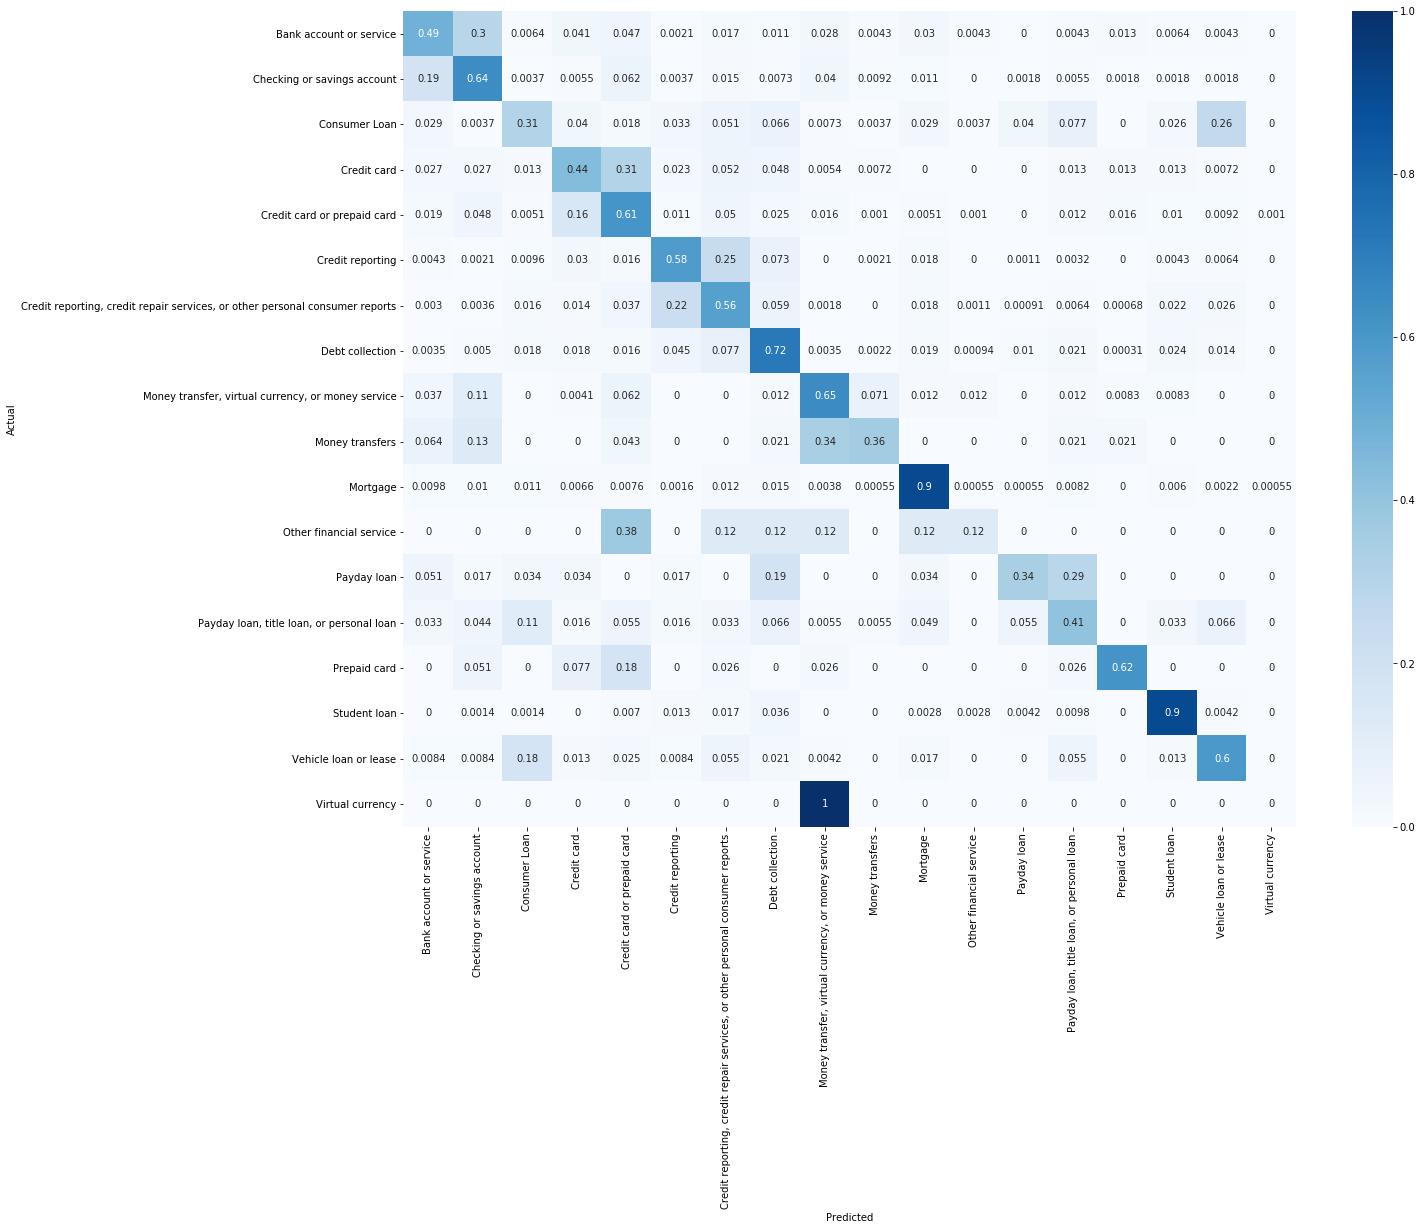

In [17]:
import seaborn as sn
import numpy as np

cm=metrics.confusion_matrix(y_test, y_pred)
data = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# data = metrics.confusion_matrix(y_test, y_pred,normalize='true')

# sns.heatmap(metrics.confusion_matrix(y_test,y_pred))

df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (20,15))
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 10})# font size

### SVC

In [18]:
t1 = time.time()
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train_tfid, y_train)
print(time.time()-t1," Secs")

652.5724170207977  Secs


In [19]:
t1 = time.time()
y_pred = svclassifier.predict(X_test_tfid)
print(time.time()-t1," Secs")

print(classification_report(y_test, y_pred,list(y_test.unique())))

157.24996137619019  Secs


C:\Users\31202\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                              precision    recall  f1-score   support

                                                                 Credit card       0.35      0.46      0.40       558
Credit reporting, credit repair services, or other personal consumer reports       0.72      0.70      0.71      4388
                          Money transfer, virtual currency, or money service       0.61      0.59      0.60       241
                                                             Debt collection       0.78      0.70      0.73      3180
                                                            Credit reporting       0.35      0.44      0.39       933
                                                     Bank account or service       0.41      0.51      0.46       467
                                                                    Mortgage       0.89      0.84      0.87      1831
                                                       

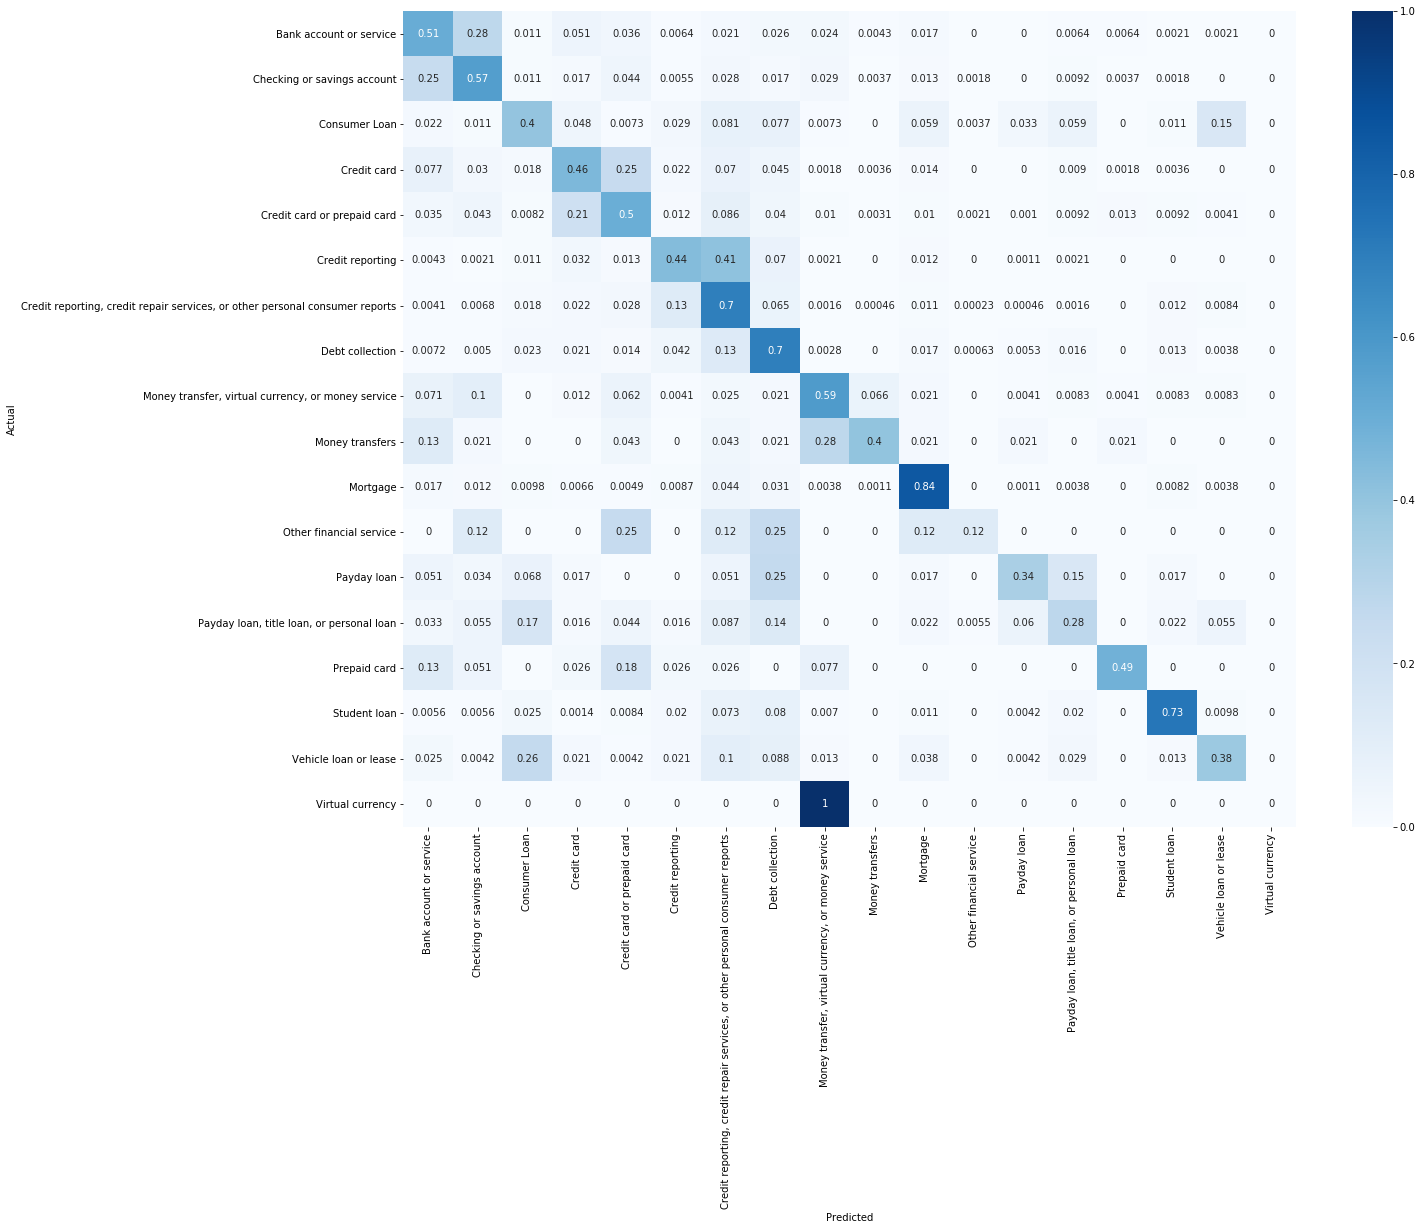

In [20]:
data = metrics.confusion_matrix(y_test, y_pred,normalize='true')

# sns.heatmap(metrics.confusion_matrix(y_test,y_pred))

df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (20,15))
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 10})# font size